In [2]:
import datasets
import matplotlib
from datasets import Dataset
from transformers import AutoTokenizer
import matplotlib.pylab as plt
import numpy as np

/home/gbrun/miniforge3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [ ]:
def chat_len(chat):
    return sum([len(msg['content']) for msg in chat])

def process_dataset(ds, model_name, logprobs = False):
    """
    Take a chat dataset as input and return input messages ans Sampling Parameters for the result
    """
    inputs = []
    outputs = []

    for chat in ds["conversation"]:
        # Take everything except last message as "input", last message as "response"
        input_chat = chat[:-1]
        response = chat[-1]

        in_len = chat_len(input_chat)
        out_len = chat_len([response])

        # Only keep examples whose input/output lengths are between 64 and 20,000 chars
        if 64 <= in_len <= 20000 and 64 <= out_len <= 20000:
            inputs.append(input_chat)
            outputs.append(response)

    # Create a small Dataset from the filtered outputs
    outputs_ds = Dataset.from_list(outputs)

    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

    def len_in_tokens(batch):
        enc = tokenizer(
            batch["content"],
            truncation=False,
            padding=False,
            return_attention_mask=False,
        )
        return {"out_len": [len(ids) for ids in enc["input_ids"]]}

    out_lengths_ds = outputs_ds.map(
        len_in_tokens,
        batched=True,
        batch_size=256,
        num_proc=64
    )

    out_lengths = out_lengths_ds["out_len"]

    # Make sure we still have exactly 1,000 examples after filtering
    # assert len(inputs) == len(sampling_params) and len(inputs) == 1000

    return inputs, out_lengths


In [4]:
ds = datasets.load_dataset("lmsys/lmsys-chat-1m", split="train[0:1483]")

In [5]:
inputs, out_lengths_ds = process_dataset(ds, "meta-llama/Llama-3.1-8B-Instruct")

Map (num_proc=64): 100%|██████████| 1000/1000 [00:14<00:00, 67.52 examples/s]


In [6]:
inputs[0]

[{'content': 'how can identity protection services help protect me against identity theft',
  'role': 'user'}]

In [7]:
def save_list_to_txt(items, filename):
    """
    Save a list of items to a text file, one item per line.

    :param items: Iterable of items (will be converted to strings)
    :param filename: Path to the output .txt file
    """
    with open(filename, 'w', encoding='utf-8') as f:
        for item in items:
            f.write(f"{item}\n")


In [8]:
save_list_to_txt(inputs, "inputs_chat_format.txt")

In [9]:
save_list_to_txt(out_lengths_ds, "out_lenghts.txt")

<BarContainer object of 1000 artists>

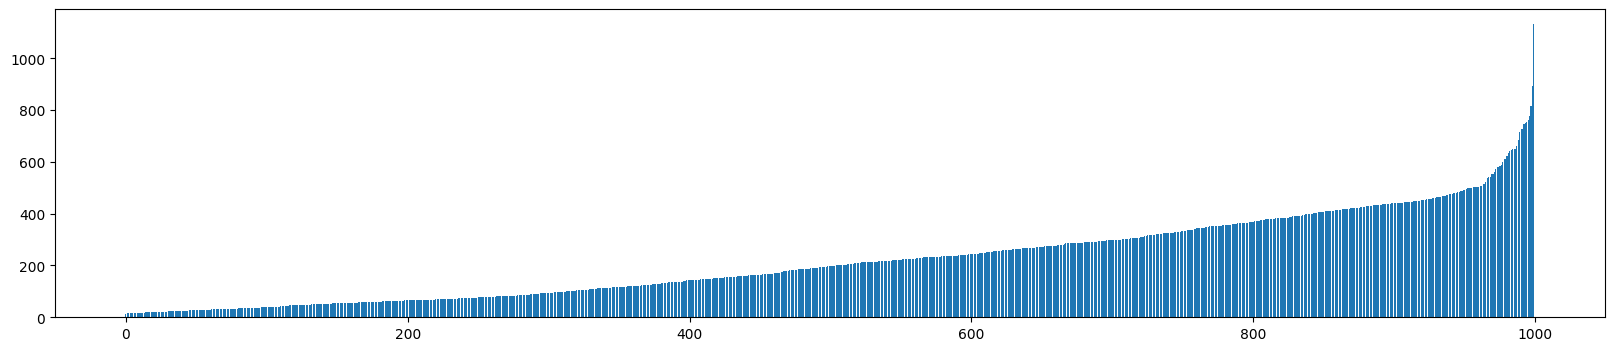

In [11]:
plt.figure(figsize=(20, 4))

plt.bar(range(len(out_lengths_ds)), sorted(out_lengths_ds))

In [ ]:
from typing import List, Dict

def to_llama_prompt(
    messages: List[Dict[str, str]],
    add_response_prompt: bool = True
) -> str:
    bos_token = "<|begin_of_text|>"
    start_fmt = "<|start_header_id|>{role}<|end_header_id|>\n"
    end_msg = "<|eot_id|>"

    parts = [bos_token]
    for msg in messages:
        role = msg["role"]
        content = msg["content"].strip()
        parts.append(start_fmt.format(role=role))
        parts.append(content + end_msg)
    if add_response_prompt:
        parts.append("<|start_header_id|>assistant<|end_header_id|>\n")
    return "".join(parts).replace('\n', '\\n')


In [ ]:
inputs_with_template = [to_llama_prompt(chat) for chat in inputs]

In [ ]:
save_list_to_txt(inputs_with_template, "inputs_with_template.txt")